In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import files
filename = files.upload()
filename.keys()

dict_keys([])

In [4]:
# Get custom image filepaths
import random

user_input = int(input("""
press 1 to upload image:
press 2 to pick random image for testing:
"""))

if user_input == 1:
    # custom_image_link = input("Enter image url path: ")
    # download_image(custom_image_link)

    custom_image_path = [input("Enter path: ")]
    custom_image_path = list(filename.keys())

elif user_input == 2:
    custom_image_path = [
    f"/content/drive/MyDrive/TerrainPrediction/images/{random.randrange(start= 0, stop= 356)}.jpg",
    f"/content/drive/MyDrive/TerrainPrediction/images/{random.randrange(start= 357, stop= 724)}.jpg",
    f"/content/drive/MyDrive/TerrainPrediction/images/{random.randrange(start= 725, stop= 824)}.jpg"
] #tensors requires list for conversion

else:
    print("unhandled_input")


press 1 to upload image:
press 2 to pick random image for testing:
2


In [5]:
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(img_path: str, img_size: int = IMG_SIZE) -> tf.Tensor:
    """ # DocString
    Takes an image file path and turns into a Tensor.
    """
    # Read in an image file
    image = tf.io.read_file(filename= img_path)

    # Turn the jped image into numerical Tensor with 3 color channel (Red, Green, Blue)
    image = tf.image.decode_jpeg(contents= image, channels= 3) # content = image as we read the image path above

    # convert the color channel values from 0 - 255 to 0 - 1 values / normalization
    image = tf.image.convert_image_dtype(image= image, dtype= tf.float32) # Convert image to dtype, scaling its values if needed.
    # dtype= tf.float32 or image = image / 255.0 both are same

    # Resize the image to our desired value (224, 224)
    image = tf.image.resize(images= image, size= (img_size, img_size))

    return image

In [6]:
BATCH_SIZE: int = 32

def create_data_batches(X, y= None, batch_size: int= BATCH_SIZE, valid_data: bool= False, test_data: bool= False):
    """ # DcoString
    Creates batches of data out of image (X) and label (y) pairs.
    Shuffles the data if it's training data but doesn't shuffle if it's validation data.
    Also accepts test data as input (no labels).
    """
    # If the data is test dataset, we probably don't have labels
    if test_data:
        print('Creating test data batches...') # for conifirmation

        # Turn filepaths and labels into Tensors
        # tf.data.Dataset - is how to create dataset in tf, from_tensor_slices - Creates a Dataset whose elements are slices of the given tensors.
        data = tf.data.Dataset.from_tensor_slices(tf.constant(X)) # convert X to tensor by tf.constant, and only filepaths (no labels)
        # Transforming
        # map - Maps map_func across the elements of this dataset.
        data_batch = data.map(map_func= process_image).batch(batch_size= BATCH_SIZE) # batch(n) splits elements into n size set
        return data_batch           # process_image() function we created above

In [7]:
# Turn custom_images to data batches
custom_data = create_data_batches(X= custom_image_path, test_data= True)
custom_data

Creating test data batches...


<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [8]:
# Create a function to load a trained model
def load_model(model_path):
    """ # DocString
    Loads a saved model from a specified path.
    """
    print(f"Loading a model from: {model_path}")
    load_model = tf.keras.models.load_model(filepath= model_path, # Loads a model saved via model.save()
                                            custom_objects= {"KerasLayer": hub.KerasLayer})
    return load_model                                       # hub.KerasLayer is used when we trained our model

In [9]:
# Loading full model
loaded_full_model = load_model(model_path= "/content/drive/MyDrive/TerrainPrediction/Trained models/20220422-10041650621891-Terrain-Road-prediction-model-mobilenetv2-Adam.h5")

Loading a model from: /content/drive/MyDrive/TerrainPrediction/Trained models/20220422-10041650621891-Terrain-Road-prediction-model-mobilenetv2-Adam.h5


In [10]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

1/1 [==============================] - 7s 7s/step


In [11]:
 # Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("/content/drive/MyDrive/TerrainPrediction/TerrainDataset - Sheet1.csv")

labels = labels_csv.road_type.to_numpy()

unique_roads = np.unique(labels)

In [12]:
# Turn prediction probabilities into thier respective label (easier to understand)
def get_pred_label(prediction_probabilities):
    """ # DocString
    Turns an array of prediction probabilities into a label
    """
    return unique_roads[np.argmax(prediction_probabilities)]

In [17]:
# Get custom image prediction labels
custom_pred_label = [get_pred_label(prediction_probabilities= custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_label,

(['Pothole', 'Plain', 'Grass'],
 array([[3.7258673e-08, 1.0421825e-07, 9.9999988e-01],
        [4.6916321e-07, 9.9994099e-01, 5.8477806e-05],
        [9.9444842e-01, 6.9881027e-04, 4.8527517e-03]], dtype=float32))

In [14]:
custom_images = []

# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
    custom_images.append(image) # for displaying using plt.imshow()

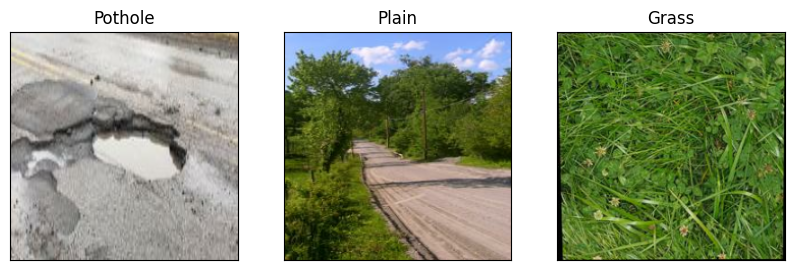

In [15]:
# result of custom image prediction
plt.figure(figsize= (10, 10))
for i, image in enumerate(custom_images):
        # nrow, ncol, index
    plt.subplot(1, len(custom_images), i + 1) # index should not be 0 show i + 1

    plt.imshow(X= image)

    plt.title(custom_pred_label[i])
    plt.xticks([])
    plt.yticks([])